In [1]:
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision import transforms

class VideoDataset(Dataset):
    def __init__(self, npz_path, transform=None, target_size=(224, 224)):
        """
        PyTorch Dataset for loading videos and labels with fixed frame count.

        Args:
            npz_path (str): Path to the .npz file.
            transform (callable, optional): Transformations to apply to video frames.
            target_size (tuple): Target frame size (height, width) for resizing.
        """
        self.data = np.load(npz_path, allow_pickle=True)
        self.keys = list(self.data.keys())  # All keys in the .npz file
        self.transform = transform
        self.target_size = target_size

    def __len__(self):
        return len(self.keys)

    def __getitem__(self, idx):
        # Load video and label from the .npz file
        key = self.keys[idx]
        item = self.data[key].item()  # Extract dictionary from object array
        video = item["video"]  # NumPy array, shape: (30, height, width, channels)
        label = item["label"]

        # Process video frames
        video = self._process_video(video)
        video = video.permute(1,0,2,3)  # 从 [T, H, W, C] 转换为 [C, T, H, W]

        label = int(label)
        # Convert label to tensor
        label = torch.tensor(label, dtype=torch.long)

        return video, label

    def _process_video(self, video):
        """
        Process video frames: resize frames and apply optional transformations.
        """
        processed_frames = []

        for frame in video:
            # Resize each frame to target size
            frame = transforms.ToPILImage()(frame)  # Convert NumPy array to PIL image
            frame = frame.resize(self.target_size)  # Resize to target size
            frame = transforms.ToTensor()(frame)   # Convert to Tensor
            if self.transform:
                frame = self.transform(frame)      # Apply additional transforms
            processed_frames.append(frame)

        # Convert processed frames to a tensor
        video_tensor = torch.stack(processed_frames)

        return video_tensor


In [2]:
train_dataset = VideoDataset(
    npz_path="./gesture-recognition-dataset/train_data_combined.npz",
    transform=transforms.Normalize(mean=[0.5], std=[0.5]),  # Normalize frames
    target_size=(224, 224)
)

val_dataset = VideoDataset(
    npz_path="./gesture-recognition-dataset/val_data_combined.npz",
    transform=transforms.Normalize(mean=[0.5], std=[0.5]),  # Normalize frames
    target_size=(224, 224)
)

print(f"Dataset size: {len(train_dataset)}")

# check a sample
video, label = train_dataset[0]
print(f"Video shape: {video.shape}, Label: {label}")

video, label = val_dataset[0]
print(f"Video shape: {video.shape}, Label: {label}")

Dataset size: 663
Video shape: torch.Size([3, 30, 224, 224]), Label: 0
Video shape: torch.Size([3, 30, 224, 224]), Label: 0


In [3]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=0)
for batch in train_loader:
    print(batch[0].shape) # input data
    print(batch[1].shape)  # label
    break
for batch in val_loader:
    print(batch[0].shape)
    print(batch[1].shape)
    break


torch.Size([4, 3, 30, 224, 224])
torch.Size([4])
torch.Size([4, 3, 30, 224, 224])
torch.Size([4])


In [11]:
from TCN import TCNWithResNet
import torch.nn as nn

tcn_model = TCNWithResNet(in_channels=512, num_classes=5)

/Users/zihang/anaconda3/envs/torch/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/zihang/anaconda3/envs/torch/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
import matplotlib.pyplot as plt

def plot_metrics(train_loss_list, val_loss_list, train_acc_list, val_acc_list, train_auc_list, val_auc_list):
    plt.figure()
    plt.plot(train_loss_list, label='train_loss')
    if val_loss_list:
        plt.plot(val_loss_list, label='val_loss')
    plt.yscale('log')  # Apply log scaling to the y-axis
    plt.legend()
    plt.title('Loss (Log Scale)')
    plt.show()

    plt.figure()
    plt.plot(train_acc_list, label='train_acc')
    if val_acc_list:
        plt.plot(val_acc_list, label='val_acc')
    plt.legend()
    plt.title('Accuracy')
    plt.show()

    plt.figure()
    plt.plot(train_auc_list, label='train_auc')
    if val_auc_list:
        plt.plot(val_auc_list, label='val_auc')
    plt.legend()
    plt.title('AUC')
    plt.show()

In [13]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.transforms import Normalize
from tqdm import tqdm
from sklearn.metrics import roc_auc_score
import numpy as np
from torch.nn import functional as F


def train_model(model, train_loader, val_loader=None, num_epochs=10, device='cuda', lr=0.001, log_dir="./logs"):
    """
    Train a given model using the specified dataset and parameters.

    Args:
        model (nn.Module): The model to train.
        train_loader (DataLoader): DataLoader for the training dataset.
        val_loader (DataLoader, optional): DataLoader for the validation dataset.
        num_epochs (int): Number of epochs to train.
        device (str): Device to train on ('cuda' or 'cpu').
        lr (float): Learning rate for the optimizer.

    Returns:
        model: The trained model.
    """
    # Move model to the specified device
    model = model.to(device)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    best_val_auc = 0.0
    best_val_acc = 0.0
    best_model_path_acc = 'best_model_acc.pth'
    best_model_path_auc = 'best_model_auc.pth'

    train_loss_list= []
    train_acc_list = []
    train_auc_list = []
    val_loss_list = []
    val_acc_list = []
    val_auc_list = []

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct = 0
        total = 0
        all_labels = []
        all_outputs = []

        print(f"Epoch {epoch + 1}/{num_epochs}")
        for videos, labels in tqdm(train_loader):
            # Move data to device
            videos, labels = videos.to(device), labels.to(device)

            # Forward pass
            outputs = model(videos)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update training statistics
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_outputs.extend(F.softmax(outputs, dim=1).cpu().detach().numpy())

        train_acc = 100. * correct / total
        train_auc = roc_auc_score(all_labels, all_outputs, multi_class='ovr')
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Train AUC: {train_auc:.2f}")
        
        # Log training metrics to TensorBoard
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        train_auc_list.append(train_auc)

        # Validation
        if val_loader:
            model.eval()
            val_loss = 0
            correct = 0
            total = 0
            all_labels = []
            all_outputs = []
            with torch.no_grad():
                for videos, labels in val_loader:
                    videos, labels = videos.to(device), labels.to(device)
                    outputs = model(videos)
                    loss = criterion(outputs, labels)

                    val_loss += loss.item()
                    _, predicted = outputs.max(1)
                    total += labels.size(0)
                    correct += predicted.eq(labels).sum().item()
                    all_labels.extend(labels.cpu().numpy())
                    all_outputs.extend(F.softmax(outputs, dim=1).cpu().detach().numpy())

            val_acc = 100. * correct / total
            val_auc = roc_auc_score(all_labels, all_outputs, multi_class='ovr')
            print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%, Validation AUC: {val_auc:.2f}")

            # Log validation metrics to TensorBoard
            val_loss_list.append(val_loss)
            val_acc_list.append(val_acc)
            val_auc_list.append(val_auc)

            # Save the model if it has the best validation AUC so far
            if val_auc > best_val_auc:
                best_val_auc = val_auc
                torch.save(model.state_dict(), best_model_path_auc)
                print(f"Saved best model with AUC: {best_val_auc:.4f}")

            # Save the model if it has the best validation Accuracy so far
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                torch.save(model.state_dict(), best_model_path_acc)
                print(f"Saved best model with Accuracy: {best_val_acc:.2f}%")

    # draw the loss and acc and auc in python
    plot_metrics(train_loss_list, val_loss_list, train_acc_list, val_acc_list, train_auc_list, val_auc_list)



    return model


Epoch 1/20


100%|██████████| 166/166 [01:54<00:00,  1.45it/s]


Train Loss: 230.4712, Train Accuracy: 36.95%, Train AUC: 0.74
Validation Loss: 38.6729, Validation Accuracy: 33.00%, Validation AUC: 0.82
Saved best model with AUC: 0.8205
Saved best model with Accuracy: 33.00%
Epoch 2/20


100%|██████████| 166/166 [01:48<00:00,  1.53it/s]


Train Loss: 213.0770, Train Accuracy: 44.04%, Train AUC: 0.78
Validation Loss: 38.7132, Validation Accuracy: 47.00%, Validation AUC: 0.76
Saved best model with Accuracy: 47.00%
Epoch 3/20


100%|██████████| 166/166 [01:48<00:00,  1.52it/s]


Train Loss: 210.3128, Train Accuracy: 41.63%, Train AUC: 0.77
Validation Loss: 28.8657, Validation Accuracy: 41.00%, Validation AUC: 0.84
Saved best model with AUC: 0.8376
Epoch 4/20


100%|██████████| 166/166 [01:48<00:00,  1.53it/s]


Train Loss: 206.9925, Train Accuracy: 44.80%, Train AUC: 0.79
Validation Loss: 31.8959, Validation Accuracy: 48.00%, Validation AUC: 0.83
Saved best model with Accuracy: 48.00%
Epoch 5/20


100%|██████████| 166/166 [01:48<00:00,  1.53it/s]


Train Loss: 193.0972, Train Accuracy: 49.62%, Train AUC: 0.81
Validation Loss: 38.2752, Validation Accuracy: 40.00%, Validation AUC: 0.78
Epoch 6/20


100%|██████████| 166/166 [01:49<00:00,  1.51it/s]


Train Loss: 200.4660, Train Accuracy: 49.47%, Train AUC: 0.80
Validation Loss: 41.5415, Validation Accuracy: 44.00%, Validation AUC: 0.78
Epoch 7/20


100%|██████████| 166/166 [01:53<00:00,  1.46it/s]


Train Loss: 180.5227, Train Accuracy: 54.45%, Train AUC: 0.84
Validation Loss: 40.3120, Validation Accuracy: 43.00%, Validation AUC: 0.82
Epoch 8/20


100%|██████████| 166/166 [01:49<00:00,  1.51it/s]


Train Loss: 179.6569, Train Accuracy: 51.13%, Train AUC: 0.84
Validation Loss: 65.0565, Validation Accuracy: 53.00%, Validation AUC: 0.80
Saved best model with Accuracy: 53.00%
Epoch 9/20


100%|██████████| 166/166 [01:51<00:00,  1.49it/s]


Train Loss: 171.6369, Train Accuracy: 53.85%, Train AUC: 0.85
Validation Loss: 42.4363, Validation Accuracy: 45.00%, Validation AUC: 0.82
Epoch 10/20


100%|██████████| 166/166 [01:51<00:00,  1.48it/s]


Train Loss: 158.2818, Train Accuracy: 56.41%, Train AUC: 0.88
Validation Loss: 17.6784, Validation Accuracy: 69.00%, Validation AUC: 0.93
Saved best model with AUC: 0.9317
Saved best model with Accuracy: 69.00%
Epoch 11/20


100%|██████████| 166/166 [01:49<00:00,  1.51it/s]


Train Loss: 149.6197, Train Accuracy: 62.59%, Train AUC: 0.89
Validation Loss: 19.8029, Validation Accuracy: 73.00%, Validation AUC: 0.94
Saved best model with AUC: 0.9401
Saved best model with Accuracy: 73.00%
Epoch 12/20


100%|██████████| 166/166 [01:49<00:00,  1.52it/s]


Train Loss: 149.3147, Train Accuracy: 63.95%, Train AUC: 0.89
Validation Loss: 43.1003, Validation Accuracy: 51.00%, Validation AUC: 0.85
Epoch 13/20


100%|██████████| 166/166 [01:48<00:00,  1.53it/s]


Train Loss: 133.1735, Train Accuracy: 69.83%, Train AUC: 0.92
Validation Loss: 20.9832, Validation Accuracy: 64.00%, Validation AUC: 0.93
Epoch 14/20


100%|██████████| 166/166 [01:49<00:00,  1.52it/s]


Train Loss: 127.6569, Train Accuracy: 69.83%, Train AUC: 0.92
Validation Loss: 12.7729, Validation Accuracy: 83.00%, Validation AUC: 0.98
Saved best model with AUC: 0.9819
Saved best model with Accuracy: 83.00%
Epoch 15/20


100%|██████████| 166/166 [01:49<00:00,  1.52it/s]


Train Loss: 101.5616, Train Accuracy: 77.68%, Train AUC: 0.95
Validation Loss: 11.8353, Validation Accuracy: 85.00%, Validation AUC: 0.98
Saved best model with Accuracy: 85.00%
Epoch 16/20


100%|██████████| 166/166 [01:49<00:00,  1.52it/s]


Train Loss: 95.8214, Train Accuracy: 79.03%, Train AUC: 0.96
Validation Loss: 14.2210, Validation Accuracy: 78.00%, Validation AUC: 0.97
Epoch 17/20


100%|██████████| 166/166 [01:47<00:00,  1.54it/s]


Train Loss: 79.4616, Train Accuracy: 82.65%, Train AUC: 0.97
Validation Loss: 14.1412, Validation Accuracy: 80.00%, Validation AUC: 0.98
Epoch 18/20


100%|██████████| 166/166 [01:47<00:00,  1.54it/s]


Train Loss: 67.2209, Train Accuracy: 86.73%, Train AUC: 0.98
Validation Loss: 7.8940, Validation Accuracy: 87.00%, Validation AUC: 0.99
Saved best model with AUC: 0.9860
Saved best model with Accuracy: 87.00%
Epoch 19/20


100%|██████████| 166/166 [01:48<00:00,  1.53it/s]


Train Loss: 94.8898, Train Accuracy: 79.79%, Train AUC: 0.96
Validation Loss: 14.5329, Validation Accuracy: 76.00%, Validation AUC: 0.96
Epoch 20/20


100%|██████████| 166/166 [01:49<00:00,  1.52it/s]


Train Loss: 71.8011, Train Accuracy: 84.62%, Train AUC: 0.97
Validation Loss: 15.8971, Validation Accuracy: 78.00%, Validation AUC: 0.96


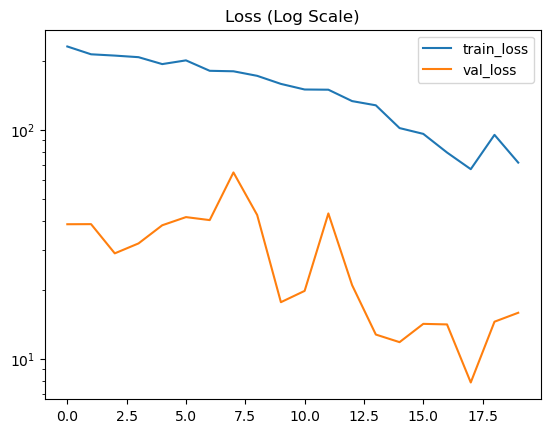

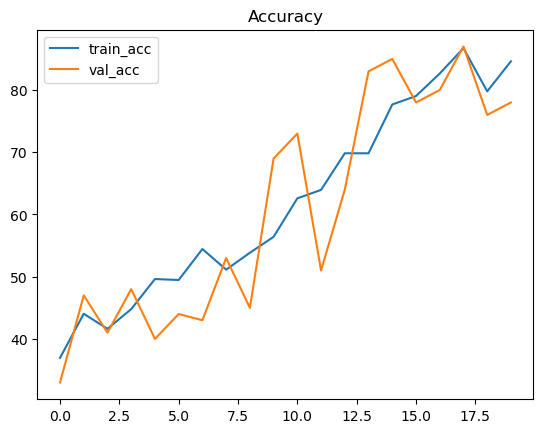

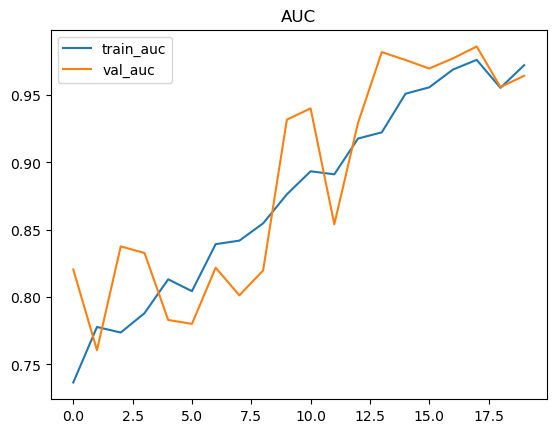

In [14]:
train_tcn = train_model(tcn_model, train_loader, val_loader, num_epochs=20, device='mps', lr=0.001)